# 📊 Financial Performance Snapshot  

## Objective

Compute and analyze core financial KPIs to assess revenue performance, cost structure, and profitability using the cleaned transactional dataset.

This notebook translates cleaned data into **actionable financial insights** suitable for executive decision-making.

---

## Scope of This Notebook

In this phase, we will:

- Load the cleaned transactional dataset
- Define financial KPIs and calculation logic explicitly
- Compute revenue, cost, and margin metrics
- Analyze performance trends over time
- Highlight key drivers and anomalies affecting financial results

This notebook focuses on **KPI computation and analysis** and does not perform raw data cleaning, which has already been convered in previous notebooks.

---

## Key KPIs Covered

The analysis will focus on the following core financial metrics:

- Total Revenue
- Total Cost
- Gross Profit
- Gross Margin (%)
- Average Order Value (AOV)
- Cost-to-Revenue Ratio
- Revenue and Profit Trends over Time

KPI definitions are documented explicitly to ensure transparency and reproducibility.

---

## Expected Outputs

By the end of this notebook, we will have:

- A set of clearly defined and computed financial KPIs
- Time-based performance views (daily / monthly)
- Identification of key trends, drivers, and outliers
- A concise set of insights suitable for executive reporting

These outputs will form the basis of the **executive summary** and any client-facing reporting tools.

---

## 1) KPI Definitions

This section defines the financial KPIs used throughout the analysis.  
All metrics are calculated at the transactional level and then aggregated as specified.


### Total Revenue

**Definition:**  
Sum of revenue generated from all completed transactions.

**Formula:**  
Total Revenue = Σ Revenue

**Notes:**  
- Calculated using the cleaned `revenue` field  
- Transactions with missing revenue were removed during the data cleaning phase

---

### Total Cost

**Definition:**  
Sum of all costs associated with completed transactions.

**Formula:**  
Total Cost = Σ Cost

**Notes:**  
- Calculated using the cleaned `cost` field  

---

### Gross Profit

**Definition:**  
Total profit generated after accounting for transaction-level costs.

**Formula:**  
Gross Profit = Total Revenue − Total Cost

**Notes:**  
- Computed at the aggregate level to avoid distortion from transaction-level volatility

---

### Gross Margin (%)

**Definition:**  
Percentage of revenue retained as profit after costs.

**Formula:**  
Gross Margin (%) = (Gross Profit / Total Revenue) × 100

**Notes:**   
- Used as a primary profitability indicator

---

### Average Order Value (AOV)

**Definition:**  
Average revenue generated per transaction.

**Formula:**  
Average Order Value = Total Revenue / Number of Transactions

**Notes:**  
- Based on completed, revenue-valid transactions  
- Sensitive to extreme revenue values (non-existant in this case)

---

### Cost-to-Revenue Ratio

**Definition:**  
Proportion of revenue consumed by costs.

**Formula:**  
Cost-to-Revenue Ratio = Total Cost / Total Revenue

**Notes:**  
- Values > 1 indicate transactions or periods operating at a loss  
- Useful for monitoring cost efficiency over time

---

### Revenue & Profit Trends

**Definition:**  
Time-based aggregation of revenue, cost, and profit metrics.

**Granularity:**  
- Daily
- Monthly

**Notes:**  
- Used to identify seasonality, growth patterns, and anomalies  
- Aggregated using transaction `order_date`

## 2) Load Clean Dataset & Validate
**Objective**

Load the cleaned transactional dataset produced in the data preparation phase and perform basic validation before computing KPIs.

In [15]:
import pandas as pd
import numpy as np

# Load cleaned dataset
df = pd.read_csv("../data/clean/financial_transactions_clean.csv", parse_dates=['order_date'])

# Basic inspection
df.shape, df.head()

((486, 6),
    order_id order_date     category payment_method  revenue    cost
 0      1001 2024-02-21  Electronics    Credit Card   728.90  530.75
 1      1002 2024-01-15  Electronics    Credit Card   587.32  422.64
 2      1003 2024-03-12  Electronics           Cash   136.99   89.15
 3      1004 2024-03-01         Home    Credit Card   223.49  156.03
 4      1005 2024-01-21  Electronics           Cash   709.37  483.00)

In [16]:
# Check for missing critical fields
df[['order_date', 'revenue', 'cost']].isna().sum()

order_date    0
revenue       0
cost          0
dtype: int64

In [17]:
# Ensure correct data types
df.dtypes

order_id                   int64
order_date        datetime64[ns]
category                  object
payment_method            object
revenue                  float64
cost                     float64
dtype: object

## 3) Compute Core Financial KPIs
**Objetive**

Compute the core financial KPIs defined earlier using the cleaned transactional dataset.

In [18]:
# Core aggregates
total_revenue = df['revenue'].sum()
total_cost = df['cost'].sum()
gross_profit = total_revenue - total_cost
gross_margin_pct = (gross_profit / total_revenue) * 100

# Transaction count
num_transactions = df.shape[0]

# Average Order Value
average_order_value = total_revenue / num_transactions

# Cost-to-Revenue Ratio
cost_to_revenue_ratio = total_cost / total_revenue

total_revenue, total_cost, gross_profit, gross_margin_pct, average_order_value, cost_to_revenue_ratio

(np.float64(143701.26),
 np.float64(88872.62),
 np.float64(54828.640000000014),
 np.float64(38.1545993403259),
 np.float64(295.6816049382716),
 np.float64(0.618454006596741))

In [19]:
# KPI Summary
kpi_summary = pd.DataFrame({
    "Metric": [
        "Total Revenue",
        "Total Cost",
        "Gross Profit",
        "Gross Margin (%)",
        "Average Order Value",
        "Cost-to-Revenue Ratio"
    ],
    "Value": [
        total_revenue,
        total_cost,
        gross_profit,
        gross_margin_pct,
        average_order_value,
        cost_to_revenue_ratio
    ]
})

# Round values for presentation
kpi_summary["Value"] = kpi_summary["Value"].round(2)

kpi_summary

,Metric,Value
0,Total Revenue,143701.26
1,Total Cost,88872.62
2,Gross Profit,54828.64
3,Gross Margin (%),38.15
4,Average Order Value,295.68
5,Cost-to-Revenue Ratio,0.62


### KPI Snapshot — Overall Performance

At an aggregate level, the business generated approximately USD **143.7K** in total revenue with associated costs of USD **88.9K**, resulting in a gross profit of USD **54.8K**.

Overall profitability appears solid, with a **gross margin of 38.15%**, indicating that a meaningful portion of revenue is retained after accounting for transaction-level costs. The **average order value of $295.68** suggests moderate revenue per transaction, consistent with a mid-ticket transactional model.

The **cost-to-revenue ratio of 0.62** implies that costs consume approximately 62% of revenue on average. While this level is sustainable at an aggregate level, further analysis is required to understand variability across time and identify periods or transactions operating at lower margins.

## 4) Time-Based KPI Analysis
**Objetive**

Analyze how revenue, costs, and profitability evolve over time. Help identify trends, seasonality, and periods of abnormal performance that are not visible in aggregate metrics.

### Daily Financial Performance

In [23]:
# Create daily aggregates
daily_kpis = (df.groupby('order_date')
    .agg(
        daily_revenue=('revenue', 'sum'),
        daily_cost=('cost', 'sum'),
        transactions=('revenue', 'count')).reset_index())

# Compute profit and margin
daily_kpis['daily_profit'] = daily_kpis['daily_revenue'] - daily_kpis['daily_cost']
daily_kpis['daily_margin_pct'] = ((daily_kpis['daily_profit'] / daily_kpis['daily_revenue']) * 100).round(2)

daily_kpis.head()

,order_date,daily_revenue,daily_cost,transactions,daily_profit,daily_margin_pct
0,2024-01-01,2841.07,1676.56,9,1164.51,40.99
1,2024-01-02,3492.13,2113.69,11,1378.44,39.47
2,2024-01-03,1643.84,1049.93,7,593.91,36.13
3,2024-01-04,1016.00,566.83,6,449.17,44.21
4,2024-01-05,1102.88,840.34,3,262.54,23.80


In [24]:
# Daily statistics
daily_stats = daily_kpis.agg({
    'daily_revenue': ['min', 'mean', 'max'],
    'daily_margin_pct': ['min', 'mean', 'max']
}).round(2)

daily_stats

,daily_revenue,daily_margin_pct
min,47.54,21.93
mean,1579.13,38.37
max,4112.26,57.14


### Monthly Financial Performance
Monthly aggregation smooths daily volatility and highlights broader performance trends over time.

In [21]:
# Create month column
df['order_month'] = df['order_date'].dt.to_period('M').dt.to_timestamp()

# Monthly aggregates
monthly_kpis = (df.groupby('order_month')
    .agg(
        monthly_revenue=('revenue', 'sum'),
        monthly_cost=('cost', 'sum'),
        transactions=('revenue', 'count')).reset_index())

# Monthly margin
monthly_kpis['monthly_profit'] = monthly_kpis['monthly_revenue'] - monthly_kpis['monthly_cost']
monthly_kpis['monthly_margin_pct'] = ((monthly_kpis['monthly_profit'] / monthly_kpis['monthly_revenue']) * 100).round(2)

monthly_kpis

,order_month,monthly_revenue,monthly_cost,transactions,monthly_profit,monthly_margin_pct
0,2024-01-01,51500.75,33003.70,169,18497.05,35.92
1,2024-02-01,48792.01,29149.03,164,19642.98,40.26
2,2024-03-01,43408.50,26719.89,153,16688.61,38.45


## Time-Based Performance Insights

### Daily Performance Observations

- Daily revenue shows significant variability, ranging from a minimum of **USD 47.54** to a maximum of **USD 4,112.26**, with an average daily revenue of approximately **USD 1,579**.
- Daily gross margin fluctuates meaningfully across days, with margins ranging from **21.93%** to **57.14%**, and an average daily margin of **38.37%**.
- Lower-margin days are typically associated with elevated costs relative to revenue rather than a complete absence of transactional activity.
- Transaction counts vary day-to-day, contributing to observed volatility in both revenue and profitability.

These results indicate that short-term financial performance is subject to notable daily fluctuations, reinforcing the importance of evaluating trends at higher aggregation levels for strategic insights.

---

### Monthly Performance Observations

- Monthly revenue remains relatively stable across the observed period, ranging from approximately **USD 43.4K** to **USD 51.5K**.
- All months exhibit positive gross profit, with monthly profits between **USD 16.7K** and **USD 19.6K**.
- Gross margin remains consistent at the monthly level, fluctuating within a narrow band between **35.92%** and **40.26%**.
- Differences in monthly profitability appear to be primarily driven by revenue volume rather than significant shifts in cost efficiency.

Monthly aggregation smooths daily volatility and provides a clearer view of underlying financial performance trends.

---

### Implications for Further Analysis

- The wide dispersion in daily margins suggests the presence of transaction-level or operational drivers affecting short-term profitability.
- Further segmentation (e.g. by product, customer, or order characteristics) may help explain low-margin days.
- Monthly performance metrics provide a more stable foundation for benchmarking and future performance forecasting.

## 5) Financial Performance Visualizations
**Objective**

Complement the tabular analysis by highlighting trends, variability, and patterns in financial performance over time.

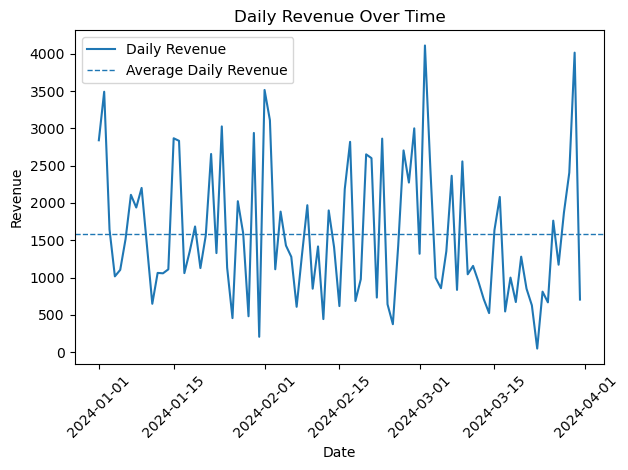

In [26]:
import matplotlib.pyplot as plt

# Daily Revenue Trend
mean_daily_revenue = daily_kpis['daily_revenue'].mean()

plt.figure()
plt.plot(daily_kpis['order_date'], daily_kpis['daily_revenue'], label="Daily Revenue")
plt.axhline(
    y=mean_daily_revenue,
    linestyle='--',
    linewidth=1,
    label="Average Daily Revenue"
)

plt.title("Daily Revenue Over Time")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

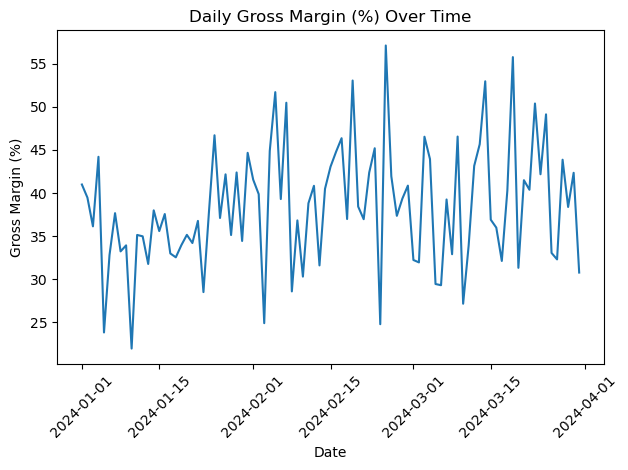

In [27]:
# Daily Gross Margin Trend
plt.figure()
plt.plot(daily_kpis['order_date'], daily_kpis['daily_margin_pct'])
plt.title("Daily Gross Margin (%) Over Time")
plt.xlabel("Date")
plt.ylabel("Gross Margin (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

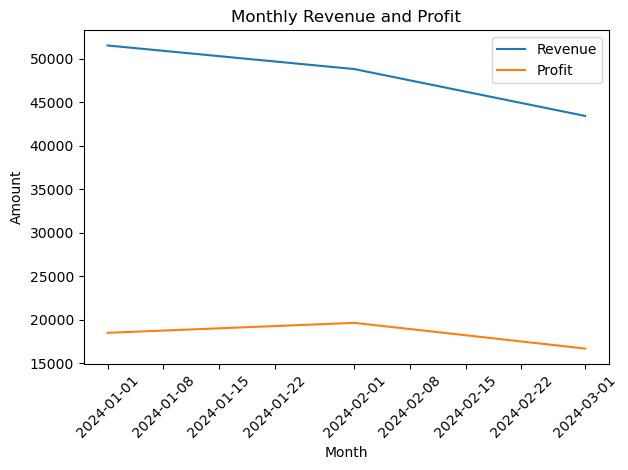

In [28]:
# Monthly Revenue & Profit Trend
plt.figure()
plt.plot(monthly_kpis['order_month'], monthly_kpis['monthly_revenue'], label="Revenue")
plt.plot(monthly_kpis['order_month'], monthly_kpis['monthly_profit'], label="Profit")
plt.title("Monthly Revenue and Profit")
plt.xlabel("Month")
plt.ylabel("Amount")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

### Visualization Summary

The time-series visualizations reinforce the findings from the tabular analysis:

- Daily revenue fluctuates significantly around the average, confirming short-term volatility in transactional performance.
- Several days fall well below the average daily revenue, while a smaller number of high-performing days drive a disproportionate share of total revenue.
- Daily gross margin varies meaningfully over time, indicating that profitability is influenced by day-specific cost dynamics rather than revenue alone.
- Monthly revenue and profit trends appear relatively stable overall, though a moderate decline is observed in the most recent period under analysis.

## 📌 Executive Summary

This project analyzed a synthetic transactional dataset to assess **financial performance**, **data quality**, and **time-based behavior** of revenues and costs over a three-month period.

### Dataset Overview
- The dataset contains **daily transaction-level records** with complete time coverage.
- All calendar days within the analysis period have at least one recorded transaction.
- Minor data quality issues were identified (e.g., missing revenue values) and handled explicitly in the cleaning phase.
- After validation, the dataset was deemed suitable for KPI computation and trend analysis.

### Overall Financial Performance
- **Total Revenue:** 143,701  
- **Total Cost:** 88,873  
- **Gross Profit:** 54,829  
- **Gross Margin:** 38.15%  
- **Average Order Value:** 295.68  
- **Cost-to-Revenue Ratio:** 0.62  

These results indicate a **consistently profitable operation**, with costs representing a controlled proportion of revenue.

### Time-Based Insights
- **Daily performance** shows meaningful variability in revenue and margins:
  - Daily revenue ranges from **~48 to ~4,112**, with an average of **~1,579**.
  - Daily gross margin averages **~38%**, with notable short-term fluctuations.
- **Monthly performance** appears relatively stable across the period:
  - Revenue, profit, and margins remain within a narrow range month-over-month.
  - A mild **downward trend** in revenue and profit is observed in the final month, warranting monitoring but not indicating a structural issue based on the available data.

### Key Takeaways
- Financial KPIs suggest **healthy margins and sustainable cost structure**.
- Short-term volatility is present at the daily level, while **monthly aggregates smooth most fluctuations**.
- No extreme anomalies were detected that would invalidate KPI interpretation.
- The analysis provides a solid baseline for **ongoing monitoring**, **forecasting**, or **scenario analysis** in future phases.

This notebook concludes the **KPI computation and exploratory analysis phase** and establishes a reliable foundation for further financial modeling or business decision support.